## 転移学習を使ってクラス分類モデルの作成

Pytorchを使い転移学習を行います。使用するデータセットはPyTorchのチュートリアルで使われている蜂と蟻のデータセットを使います。  
それぞれ120枚ずつ画像が存在し、validationに75枚の画像を使用します。  

今回のモデル作成にあたり、以下のqiitaの投稿を参考にしました。  
[qiita記事：Pytorchで転移学習@illumination-k](https://qiita.com/illumination-k/items/fa7508127d8942c1284f)

#### データセットの準備
***

dataディレクトリを作成し、その中にダウンロードしておいたデータセットをアップロードします。
 ./data/"hymenoptera_data/データセット"

#### 必要なライブラリのインポート
***

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os 
import copy

plt.ion()

os.chdir("D:\VScode\python\data_science\kadai_2_Tensorflow")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#cuda:0


cpu


#### datasetの作成
***

**train**と**validation**の data_transforms を torchvision.transforms.Compose クラスを使って作成します。  
**train**ではdata augumentationをランダムリサイズクロップとランダムフリップを行うことにします。  
また、pretrainedのモデルを使用するために正規化します。  
次に torchvison.datasets.ImageFolder クラスを使ってtransformされたデータセット image_datasetsを作成します。image_datasets と torch.utils.data.DataLoder クラスを使ってロードされるごとにbatch sizeが4でデータのシャッフルが行われるdataloadersを作成します。また、それぞれのデータセットのサイズとラベルを作成しておきます。  

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = "./data/hymenoptera_data"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


image_datasets の中身を確認して見ます。

In [3]:
print('-'*10, 'image_datasets','-'*10,'\n', image_datasets)
print()
print('-'*10,'train dataset','-'*10,'\n', image_datasets['train'])
print()
print('-'*10,'label','-'*10,'\n', image_datasets['train'].classes)

---------- image_datasets ---------- 
 {'train': Dataset ImageFolder
    Number of datapoints: 244
    Root location: ./data/hymenoptera_data\train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ), 'val': Dataset ImageFolder
    Number of datapoints: 153
    Root location: ./data/hymenoptera_data\val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )}

---------- train dataset ---------- 
 Dataset ImageFolder
    Number of datapoints: 244
    Root location: ./data/hymen

#### 訓練データの表示
***

Tensorをnumpy arrayに変換し、matplotlibを使って表示します。Tensorの形状をimashowで表示できるように変換して表示します。  
実行するたびに毎回違う写真が表示されます。

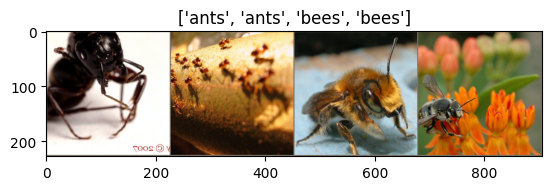

In [4]:
def imshow(inp, title=None):
    "imshow for Tensor"
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)
imshow(out, title = [class_names[x] for x in classes])

#### モデル、損失関数、ハイパーパラメータの定義
***

モデルとしてpre-trainedなResNet18を使用し、次元出力を2次元にして二値分類を行います。  
損失関数として交差クロスエントロピー誤差、最適化法として MomentumSGD を使用します。  

In [5]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

c:\Users\takar\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\takar\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### 訓練
*** 

epoch内部でそれぞれのrunごとにlossとaccuracyを算出してepoch全体での平均のlossとaccuracyを表示します。**train**のときは model.train() , **validation** や **test**のときは model.eval() を使うと良いようです。

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    #tensor(max, max_indices)なのでpredは0,1のラベル
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# training
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)


Epoch 0/24
----------


c:\Users\takar\miniconda3\Lib\site-packages\torch\optim\lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 0.5418 Acc: 0.7131
val Loss: 0.2153 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.5422 Acc: 0.7787
val Loss: 0.1827 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.3950 Acc: 0.8320
val Loss: 0.2983 Acc: 0.9150

Epoch 3/24
----------
train Loss: 0.5413 Acc: 0.7910
val Loss: 0.2616 Acc: 0.9085

Epoch 4/24
----------
train Loss: 0.3556 Acc: 0.8566
val Loss: 0.2845 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.7937 Acc: 0.7623
val Loss: 0.2795 Acc: 0.9020

Epoch 6/24
----------
train Loss: 0.4002 Acc: 0.8320
val Loss: 0.2567 Acc: 0.9085

Epoch 7/24
----------
train Loss: 0.4731 Acc: 0.8320
val Loss: 0.2267 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.2954 Acc: 0.8730
val Loss: 0.2175 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.3625 Acc: 0.8443
val Loss: 0.2231 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.3393 Acc: 0.8770
val Loss: 0.2153 Acc: 0.9085

Epoch 11/24
----------
train Loss: 0.2880 Acc: 0.8852
val Loss: 0.2108 Acc: 0.9281

Epoch 12/24
----------
t

#### 訓練結果
***


Best val accuracy = 0.934641 となり、かなりの精度となりました。

#### Validationデータの表示
***

どのような予測が行われているのか表示します。

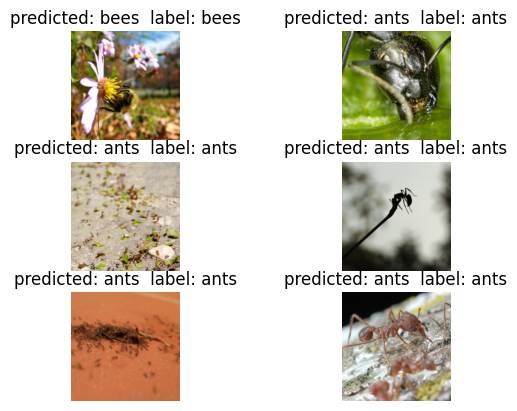

In [7]:
def tensor_to_np(inp):
  "imshow for Tensor"
  inp = inp.numpy().transpose((1,2,0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  return inp

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = fig.add_subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}  label: {}'
                             .format(class_names[preds[j]], class_names[labels[j]]))
                ax.imshow(tensor_to_np(inputs.cpu().data[j]))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

visualize_model(model_ft)

#### 結論
***

別の学習方法のほうが早くかつ精度も出そうですが、転移学習を使ってクラス分類モデルを作成できました。